In [1]:
# -*- coding: utf-8 -*-
"""Tests gnnad for alignment with original code."""

__author__ = ["KatieBuc"]

import numpy as np
import pandas as pd
from sklearn.utils.validation import check_random_state

from gnnad.graphanomaly import GNNAD

random_state = 245
rng = check_random_state(random_state)

# generate multivariate data
cov = [[0.5, 0.3, 0], [0.3, 1.0, 0], [0, 0, 0.8]]
mean = [1, 3, 10]
X_train = (
    pd.DataFrame(rng.multivariate_normal(mean=mean, cov=cov, size=2000))
    .ewm(span=2)
    .mean()
)
X_test = (
    pd.DataFrame(rng.multivariate_normal(mean=mean, cov=cov, size=1000))
    .ewm(span=2)
    .mean()
)

# add anomalies to the test set
X_test.iloc[342:356, :] *= 2
X_test.iloc[752:772, 0:2] *= 0.01

# anomaly labels
y_test = np.zeros(len(X_test))
y_test[342:356] = 1
y_test[752:772] = 1


def test_fitted_model():
    """This model is tested against _[1], with the above generated code.
    To run the _original_ code, this data needs to be saved as csv's locally.

    X_test['attack'] = y_test
    X_train.to_csv('data/unit_test/train.csv')
    X_test.to_csv('data/unit_test/test.csv')

    Then, in the terminal run:
    python main.py -dataset unit_test -device cpu -topk 2 -epoch 10

    References
    ----------
    _[1] https://github.com/d-ailin/GDN
    """

    model = GNNAD(shuffle_train=False, topk=2, epoch=10, save_model_name="test")
    fitted_model = model.fit(X_train, X_test, y_test)

    f1_actual = fitted_model.f1
    precision_actual = fitted_model.precision
    recall_actual = fitted_model.recall

    f1_expected = 0.5384615384615384
    precision_expected = 0.8235294117647058
    recall_expected = 0.4117647058823529

    assert np.allclose(f1_actual, f1_expected)
    assert np.allclose(precision_actual, precision_expected)
    assert np.allclose(recall_actual, recall_expected)


test_fitted_model()

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


epoch (0 / 10) (Loss:40.17884064, ACU_loss:120.53652191)
epoch (1 / 10) (Loss:39.03404490, ACU_loss:117.10213470)
epoch (2 / 10) (Loss:37.60780589, ACU_loss:112.82341766)
epoch (3 / 10) (Loss:36.32013067, ACU_loss:108.96039200)
epoch (4 / 10) (Loss:35.13179779, ACU_loss:105.39539337)
epoch (5 / 10) (Loss:34.05962372, ACU_loss:102.17887115)
epoch (6 / 10) (Loss:34.34579849, ACU_loss:103.03739548)
epoch (7 / 10) (Loss:33.31120809, ACU_loss:99.93362427)
epoch (8 / 10) (Loss:32.25991440, ACU_loss:96.77974319)
epoch (9 / 10) (Loss:31.17664210, ACU_loss:93.52992630)
=========================** Result **============================

F1 score: 0.5384615384615384
precision: 0.8235294117647058
recall: 0.4117647058823529



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from gnnad.graphanomaly import GNNAD
from gnnad.generate import GenerateGaussian, GenerateAnomaly

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


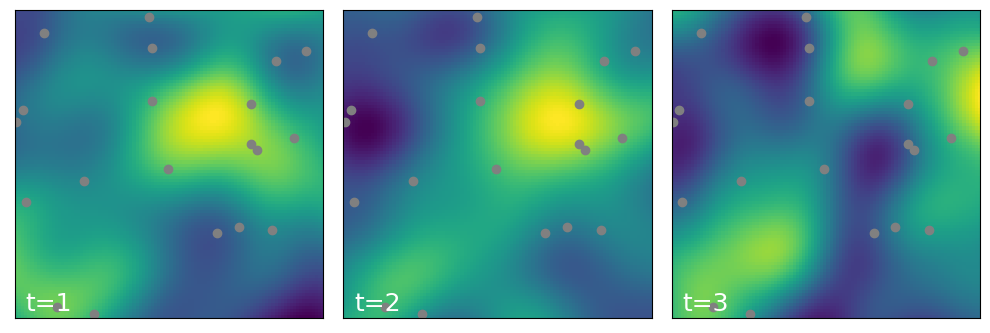

In [2]:
# generate data
gengauss = GenerateGaussian()
X = gengauss.generate()
gengauss.field_plot()


In [3]:
# split train test
X_train, X_test = train_test_split(X, shuffle=False)

# generate anomalies on test set
anoms = GenerateAnomaly(X_test)
X_test = anoms.generate_anomaly(anoms.variability, lam = 3, prop_anom = 0.07, seed=45)
X_test = anoms.generate_anomaly(anoms.drift, lam = 11, prop_anom = 0.07, seed=234)
y_test = anoms.get_labels()

# TODO: plot input data

<AxesSubplot:>

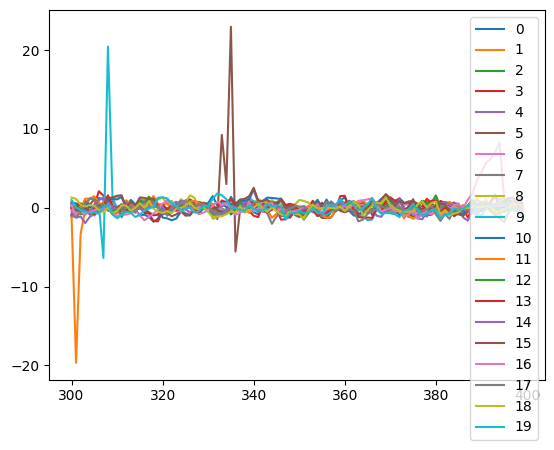

In [4]:
X_test.plot()

In [ ]:
# run model
model = GNNAD(threshold_type="max_validation", slide_win=3, topk=5)
fitted_model = model.fit(X_train, X_test, y_test)


In [ ]:
# TODO: plot results 

In [ ]:
# plot confusion matrix

df = pd.DataFrame([[110, 776, 89, 22],
             [113, 743, 122, 19],
             [96, 784, 81, 36],
             [103, 729, 136, 29]], 
             columns=['TP', 'TN', 'FP', 'FN'])


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

tp = df.TP.values
tn = df.TN.values
fp = df.FP.values
fn = df.FN.values

ind = [0, 1, 2.5, 3.5] # the x locations for the groups
width = 0.98
fig = plt.figure(figsize=(5, 5))
fig.set_tight_layout(True)
ax = fig.add_axes([0,0,1,1])

ax.bar(ind, fn, width, color='#AA4499')
ax.bar(ind, tp, width,bottom=fn, color='#332288')
ax.bar(ind, fp, width, bottom=fn+tp, color='#999933')
ax.bar(ind, tn, width, bottom=fp+fn+tp, color='#888888')
ax.set_ylabel('Number of instances')
ax.set_title('Confusion Matrix')
ax.set_xticks(ind, ('GDN', 'GDN+', 'GDN', 'GDN+'))
ax.legend(labels=['FN', 'TP', 'FP', 'TN'])

# Second X-axis
ax2 = ax.twiny()
ax2.spines["bottom"].set_position(("axes", -0.10))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xticks([0.0, 0.5, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.75]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['SimEuc', 'SimRiv']))

#plt.show()
#plt.autoscale()

#plt.savefig('ConfusionMatrix.pdf',bbox_inches='tight')